# CHIPPR

This notebook demonstrates the use of the Cosmological Hierarchical Inference with Probabilistic Photometric Redshifts (CHIPPR) package to estimate the redshift density function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import cProfile, pstats, StringIO

import chippr
from chippr import *

/Users/aimalz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
#help(chippr)

## Simulation

In [6]:
tru_amps = np.array([0.20, 0.35, 0.55])
tru_means = np.array([0.5, 0.2, 0.75])
tru_sigmas = np.array([0.4, 0.2, 0.1])

tru_nz = gmix(tru_amps, tru_means, tru_sigmas, limits=(0., 1.))

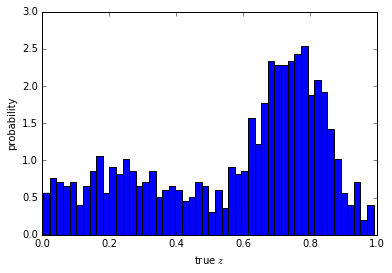

In [3]:
N = 10**3#2**16

tru_zs = tru_nz.sample(N)

plt.hist(tru_zs, bins=50, normed=1)
plt.xlabel(r'true $z$')
plt.ylabel(r'probability')

In [4]:
params = 'params.txt'
params = sim_utils.ingest(params)
print(params)

{'constant_sigma': ['0.05'], 'outlier_fraction': ['0.2'], 'variable_sigmas': ['0'], 'catastrophic_outliers': ['1'], 'outlier_mean': ['0.4'], 'outlier_sigma': ['0.075']}


In [5]:
bin_ends = np.array([0., 1.])
weights = np.array([1.])

int_prior = discrete(bin_ends, weights)

In [6]:
n_bins = 10

pr = cProfile.Profile()
pr.enable()

posteriors = catalog(params)
output = posteriors.create(tru_zs, int_prior, bins=n_bins)

data = np.exp(output['log_interim_posteriors'])

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

{'constant_sigma': 0.05, 'outlier_fraction': 0.2, 'variable_sigma': 0, 'variable_sigmas': ['0'], 'catastrophic_outliers': True, 'outlier_mean': 0.4, 'outlier_sigma': 0.075}
         64051 function calls in 0.235 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    11011    0.062    0.000    0.062    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     1001    0.049    0.000    0.175    0.000 build/bdist.macosx-10.6-x86_64/egg/chippr/catalog.py:69(coarsify)
    11011    0.039    0.000    0.119    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:1743(sum)
        1    0.013    0.013    0.235    0.235 build/bdist.macosx-10.6-x86_64/egg/chippr/catalog.py:89(create)
        1    0.010    0.010    0.029    0.029 build/bdist.macosx-10.6-x86_64/egg/chippr/catalog.py:134(sample_obs)
    11011    0.009    0.000    0.072    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/numpy/core/_methods.p

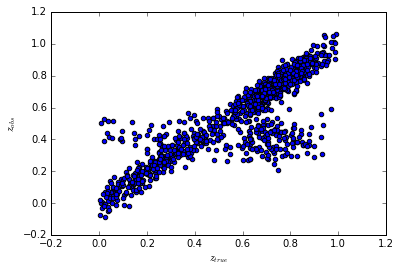

In [7]:
plt.scatter(tru_zs, posteriors.obs_samps)
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'$z_{obs}$')

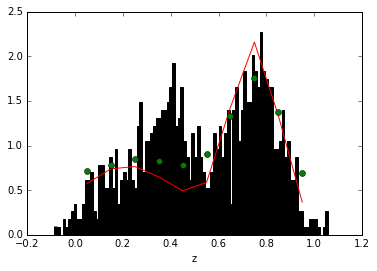

In [8]:
plt.hist(posteriors.obs_samps, bins=100, normed=True, color="k")
plt.plot(posteriors.x_coarse, tru_nz.evaluate(posteriors.x_coarse), "r-")
plt.plot(posteriors.x_coarse, np.sum(data, axis=0) / N, "go")
plt.xlabel("z")

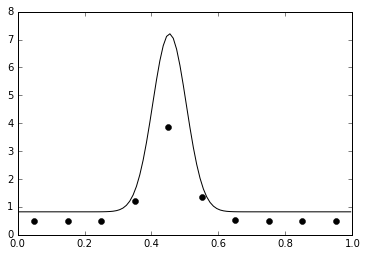

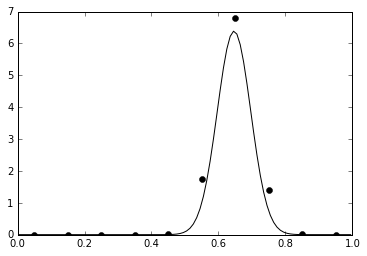

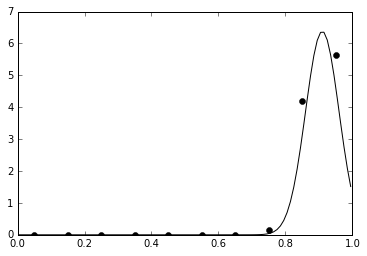

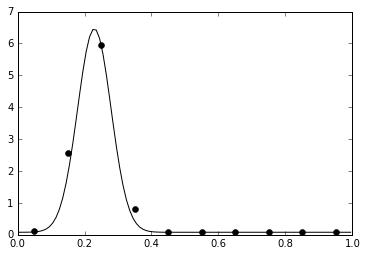

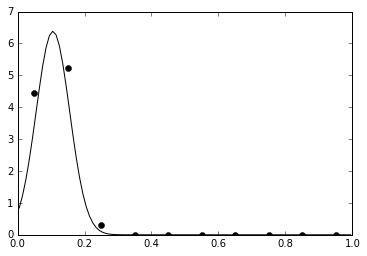

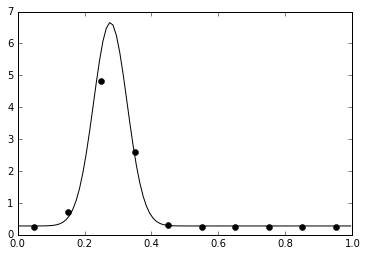

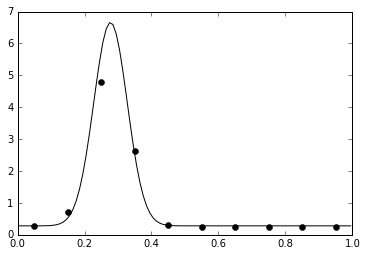

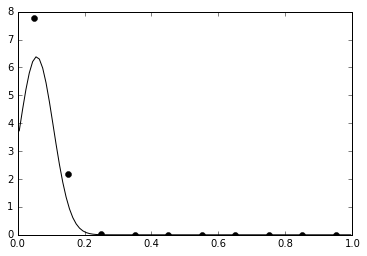

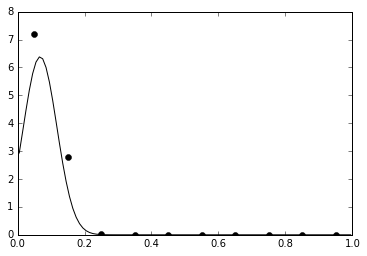

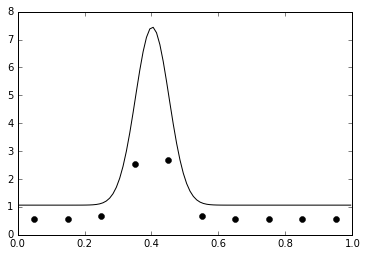

In [9]:
for n, z in enumerate(data[:10]):
    plt.plot(posteriors.x_coarse, data[n], 'ko')
    plt.plot(posteriors.x_fine, posteriors.obs_lfs[n], 'k-')
    plt.show()

In [10]:
saved_location = 'data.txt'
posteriors.write(saved_location)

## Inference

In [2]:
saved_location = 'data.txt'
simulated_posteriors = catalog()
data = simulated_posteriors.read(saved_location)

{'outlier_fraction': 0.0, 'variable_sigma': 0, 'catastrophic_outliers': 0, 'constant_sigma': 0.05}


In [3]:
zs = data['bin_ends']
nz_intp = np.exp(data['log_interim_prior'])
z_posts = np.exp(data['log_interim_posteriors'])

z_difs = zs[1:]-zs[:-1]
z_mids = (zs[1:]+zs[:-1])/2.
n_bins = len(z_mids)

In [4]:
# prior_sigma = 0.16
# prior_var = np.eye(n_bins)
# for b in range(n_bins):
#     prior_var[b] = 1. * np.exp(-0.5 * (z_mids[b] - z_mids) ** 2 / prior_sigma ** 2)
# l = 1.e-4
# prior_var = prior_var+l*np.identity(n_bins)

prior_var = np.eye(n_bins)
for k in range(n_bins):
    prior_var[k] = 1. * np.exp(-0.5 * (z_mids[k] - z_mids) ** 2 / 0.05 ** 2)

prior_mean = nz_intp
prior = mvn(prior_mean, prior_var)

In [8]:
nz = log_z_dens(data, prior, vb=True)

10 bins, 1000 interim posterior PDFs


In [9]:
nz_stacked = nz.calculate_stacked()

In [10]:
nz_mmap = nz.calculate_mmap()

In [11]:
nz_mexp = nz.calculate_mexp()

In [12]:
pr = cProfile.Profile()
pr.enable()

nz_mmle = nz.calculate_mmle(nz_stacked)

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

('starting at', array([-0.33685548, -0.24933119, -0.16657403, -0.19380474, -0.24139515,
       -0.10599007,  0.28641043,  0.56320407,  0.31656068, -0.36962509]), -145.67782743450866)
 final_simplex: (array([[-0.21210207, -0.10031166,  0.14680956, -0.28136493, -0.58732703,
        -0.08684035,  0.45212908,  1.16987964,  0.63406894, -0.96517948],
       [-0.21218718, -0.10035344,  0.14671635, -0.28141145, -0.58742696,
        -0.08692286,  0.45206183,  1.16980262,  0.63401047, -0.96526371],
       [-0.21213643, -0.10032911,  0.14677988, -0.2813607 , -0.58741614,
        -0.0868658 ,  0.45208734,  1.1698553 ,  0.63403184, -0.96523743],
       [-0.21213494, -0.1002913 ,  0.14680328, -0.2813799 , -0.58733798,
        -0.0868407 ,  0.45209073,  1.16986313,  0.63408154, -0.96520461],
       [-0.21214499, -0.10036307,  0.14678518, -0.28144737, -0.58733587,
        -0.08689153,  0.4520541 ,  1.16983392,  0.63402249, -0.96523956],
       [-0.21215024, -0.10033344,  0.14677036, -0.28140252, -0.58

In [13]:
n_ivals = 2*n_bins
initial_values = prior.sample(n_ivals)

pr = cProfile.Profile()
pr.enable()

nz_samps = nz.calculate_samples(initial_values)

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

         20645590 function calls in 16.781 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    20020    7.864    0.000   13.316    0.001 build/bdist.macosx-10.6-x86_64/egg/chippr/utils.py:10(safe_log)
 20020000    3.433    0.000    3.433    0.000 {max}
    35026    1.939    0.000    1.939    0.000 {numpy.core.multiarray.array}
    20020    1.479    0.000   16.096    0.001 build/bdist.macosx-10.6-x86_64/egg/chippr/log_z_dens.py:60(evaluate_log_hyper_likelihood)
    88084    0.992    0.000    0.992    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    60060    0.197    0.000    1.137    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:1743(sum)
     2000    0.111    0.000   16.616    0.008 /Users/aimalz/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:292(_propose_stretch)
    40040    0.080    0.000    0.080    0.000 {numpy.core.multiarray.dot}
     1001    0.079    0.000   16.769   

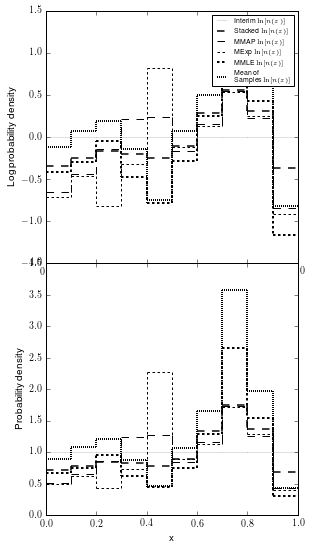

In [14]:
nz.plot()